In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
log = open("2.log").read()
log

'rm -f q1 q2 q3 *.o\ng++ -O3 -Wall -std=c++11 -o q1 q1.cpp\n/usr/local/cuda/bin/nvcc q2.cu -c -o q2.o -O3 \n/usr/local/cuda/bin/nvcc q2.o -o q2 -L/usr/local/cuda/lib64 -L/usr/local/cuda/samples/common/lib/linux/x86_64 -O3 \n/usr/local/cuda/bin/nvcc q3.cu -c -o q3.o -O3 \n/usr/local/cuda/bin/nvcc q3.o -o q3 -L/usr/local/cuda/lib64 -L/usr/local/cuda/samples/common/lib/linux/x86_64 -O3 \n\n\nRunning with K=1\nCPU-based:\nAdding arrays with 1 million elements each...\nExecution time: 1 ms\nSample results: c[0]=2, c[size/2]=2, c[size-1]=2\nNon-unified memory: \nRunning with 1 blocks and 1 threads per block, K = 1\nExecution time: 0.007168 ms\nSample results: c[0]=2, c[size/2]=0, c[size-1]=0\nRunning with 1 blocks and 256 threads per block, K = 1\nExecution time: 0.007168 ms\nSample results: c[0]=2, c[size/2]=0, c[size-1]=0\nRunning with 3907 blocks and 256 threads per block, K = 1\nExecution time: 0.01024 ms\nSample results: c[0]=2, c[size/2]=2, c[size-1]=2\nUnified memory: \nRunning with 1

In [3]:
# Prepare to store entries
entries = []

# Split the log by 'Running with K=' to find each K block
k_blocks = re.split(r'Running with K=(\d+)', log)

# Process each block
for i in range(1, len(k_blocks), 2):
    k_value = int(k_blocks[i])
    section = k_blocks[i + 1]

    # Detect and parse CPU section
    cpu_match = re.search(r'CPU-based:.*?Execution time: ([\d\.]+) ms', section, re.DOTALL)
    if cpu_match:
        entries.append({
            'K': k_value,
            'mode': 'CPU',
            'blocks': None,
            'threads_per_block': None,
            'execution_time_ms': float(cpu_match.group(1))
        })

    # Parse Non-unified memory
    non_unified_section = re.search(r'Non-unified memory:(.*?)(Unified memory:|$)', section, re.DOTALL)
    if non_unified_section:
        for match in re.finditer(r'Running with (\d+) blocks and (\d+) threads per block, K = \d+\nExecution time: ([\d\.]+) ms', non_unified_section.group(1)):
            blocks, threads, time = match.groups()
            entries.append({
                'K': k_value,
                'mode': 'Non-unified memory',
                'blocks': int(blocks),
                'threads_per_block': int(threads),
                'execution_time_ms': float(time)
            })

    # Parse Unified memory
    unified_section = re.search(r'Unified memory:(.*)', section, re.DOTALL)
    if unified_section:
        for match in re.finditer(r'Running with (\d+) blocks and (\d+) threads per block, K = \d+\nExecution time: ([\d\.]+) ms', unified_section.group(1)):
            blocks, threads, time = match.groups()
            entries.append({
                'K': k_value,
                'mode': 'Unified memory',
                'blocks': int(blocks),
                'threads_per_block': int(threads),
                'execution_time_ms': float(time)
            })

# Create DataFrame
df = pd.DataFrame(entries)

df['run_mode'] = df.apply(lambda x: '0: CPU' if x['mode'] == 'CPU' else '1: 1 block & 1 thread' if x['threads_per_block'] == 1 else '2: 1 block & 256 thread' if x['blocks'] == 1 else '3: multi block & 256 thread', axis=1)
df

,K,mode,blocks,threads_per_block,execution_time_ms,run_mode
0,1,CPU,NaN,NaN,1.000000,0: CPU
1,1,Non-unified memory,1.0,1.0,0.007168,1: 1 block & 1 thread
2,1,Non-unified memory,1.0,256.0,0.007168,2: 1 block & 256 thread
3,1,Non-unified memory,3907.0,256.0,0.010240,3: multi block & 256 thread
4,1,Unified memory,1.0,1.0,0.007168,1: 1 block & 1 thread
5,1,Unified memory,1.0,256.0,0.007168,2: 1 block & 256 thread
6,1,Unified memory,3907.0,256.0,0.013312,3: multi block & 256 thread
7,5,CPU,NaN,NaN,9.000000,0: CPU
8,5,Non-unified memory,1.0,1.0,0.021472,1: 1 block & 1 thread
9,5,Non-unified memory,1.0,256.0,0.018432,2: 1 block & 256 thread


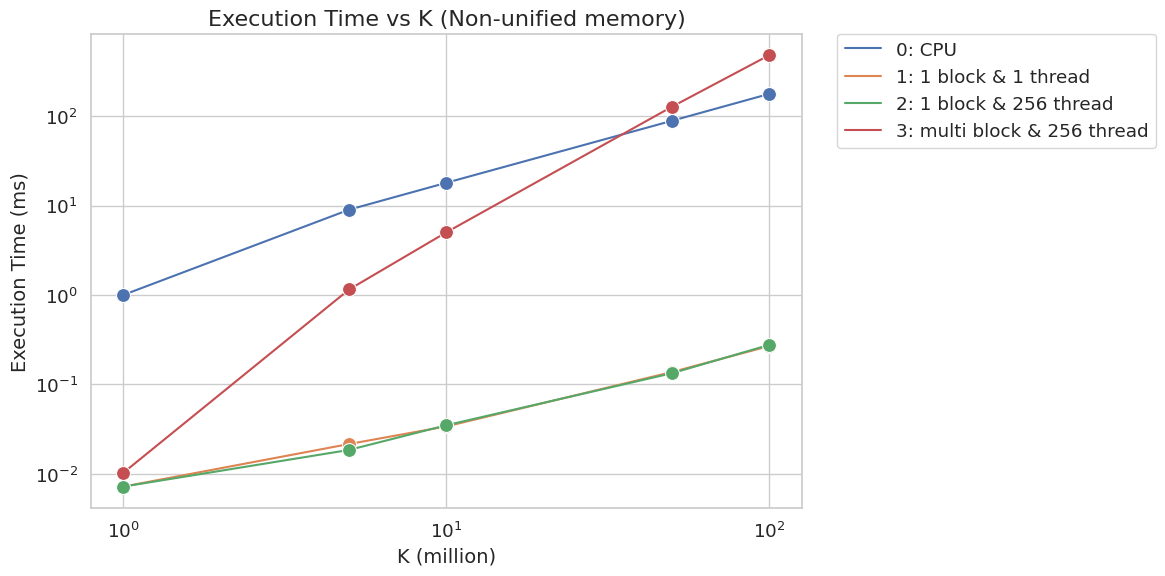

In [4]:
# x-axis: K, y-axis: execution_time_ms, color: block, shape: threads_per_block
# Optional: make sure seaborn style is nice
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Prepare the plot
plt.figure(figsize=(12, 6))

# Scatter plot with seaborn
scatter = sns.lineplot(
    data=df.query("mode == 'Non-unified memory' or mode == 'CPU'"),
    x='K',
    y='execution_time_ms',
    hue='run_mode',
    palette='deep',
    marker='o',
    dashes=False,
    markersize=10,
)

# CPU

# Titles and labels
plt.title('Execution Time vs K (Non-unified memory)', fontsize=16)
plt.xlabel('K (million)', fontsize=14)
plt.ylabel('Execution Time (ms)', fontsize=14)
plt.xscale('log')  # Log scale for K
plt.yscale('log')  # Log scale for execution time

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


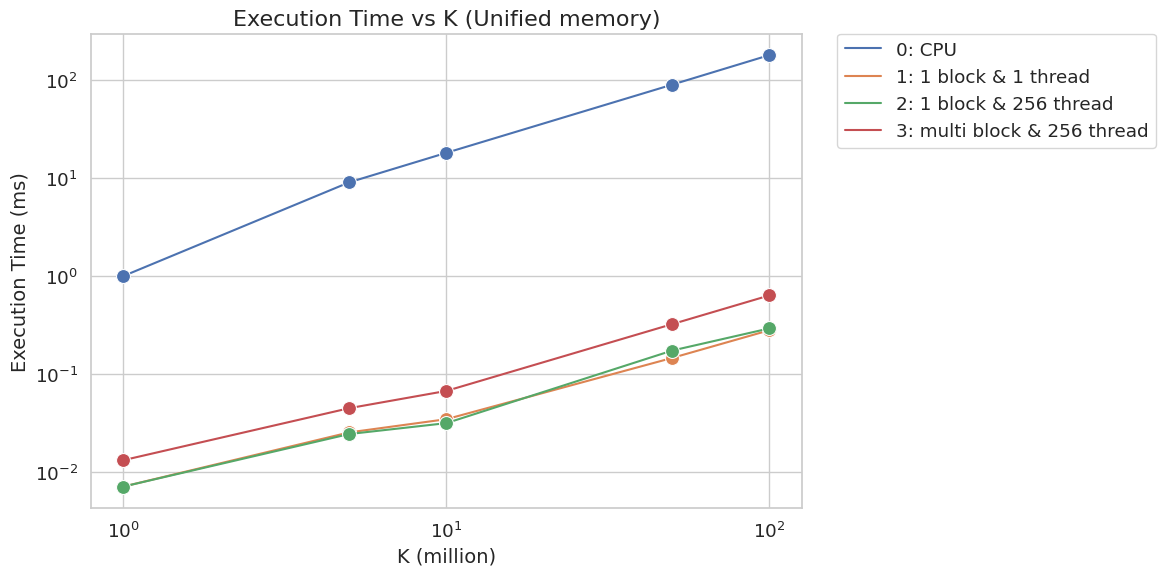

In [5]:
# Unified memory plot
plt.figure(figsize=(12, 6))
# Scatter plot with seaborn
scatter = sns.lineplot(
    data=df.query("mode == 'Unified memory' or mode == 'CPU'"),
    x='K',
    y='execution_time_ms',
    hue='run_mode',
    palette='deep',
    marker='o',
    dashes=False,
    markersize=10,
)
# Titles and labels
plt.title('Execution Time vs K (Unified memory)', fontsize=16)
plt.xlabel('K (million)', fontsize=14)
plt.ylabel('Execution Time (ms)', fontsize=14)      
plt.xscale('log')  # Log scale for K
plt.yscale('log')  # Log scale for execution time
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# Tight layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()